In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fn="../prices.txt"
df=pd.read_csv(fn, sep='\s+', header=None, index_col=None)
prices = (df.values).T

nInst ,T = 50,750

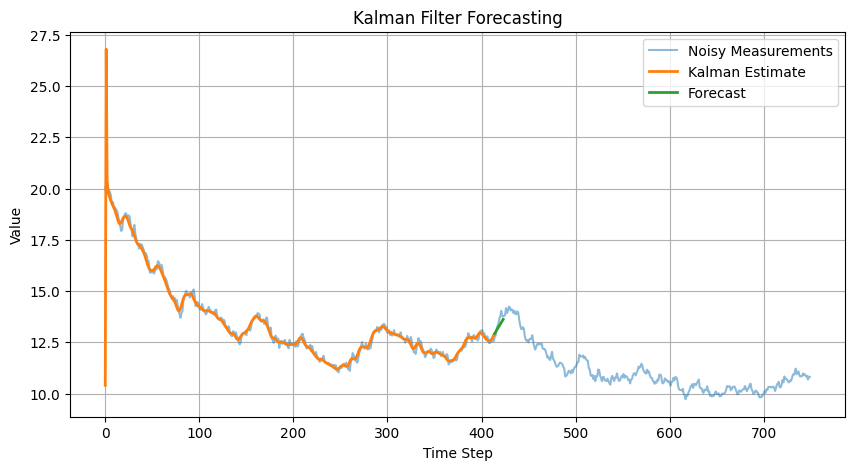

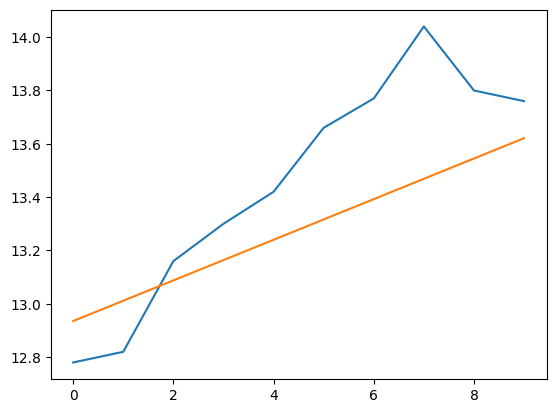

12.859170695219643 0.07619665774386154


In [110]:
# Simulate a 1D system: constant velocity + noise

instID = 33
instPrice = prices[instID]


stop = 420
measurements = instPrice[:stop]
kern = [0.5,1,2,3,2,1,0.5]
measurements = np.convolve(measurements,kern,mode="valid")/sum(kern)

# Kalman filter setup
x = 0.0           # initial estimate
v = 0.5           # initial velocity
P = 1.0           # initial uncertainty
Q = 0.05         # process noise (model uncertainty)
R = 1.0           # measurement noise
A = 1.0           # state transition (no change to state, just incremented by v)
H = 1.0           # measurement matrix
x_estimates = []

for z in measurements:
    # Predict step
    x = x + v               # predict next state
    P = P + Q               # update uncertainty

    # Update step
    v = P * (z-x)
    K = P / (P + R)         # Kalman gain
    x = x + K * (z - x)     # update estimate
    P = (1 - K) * P         # update uncertainty

    x_estimates.append(x)

# Forecast future steps
n = len(measurements)
future_steps = 10
forecast = [x + v * i for i in range(1, future_steps + 1)]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(instPrice, label='Noisy Measurements', alpha=0.5)
plt.plot(x_estimates, label='Kalman Estimate', linewidth=2)
plt.plot(np.arange(n, n+future_steps), forecast, label='Forecast', linewidth=2)
plt.legend()
plt.title("Kalman Filter Forecasting")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.grid(True)
plt.show()


plt.plot(instPrice[n:n+future_steps])
plt.plot(forecast)
plt.show()

print(x,v,)

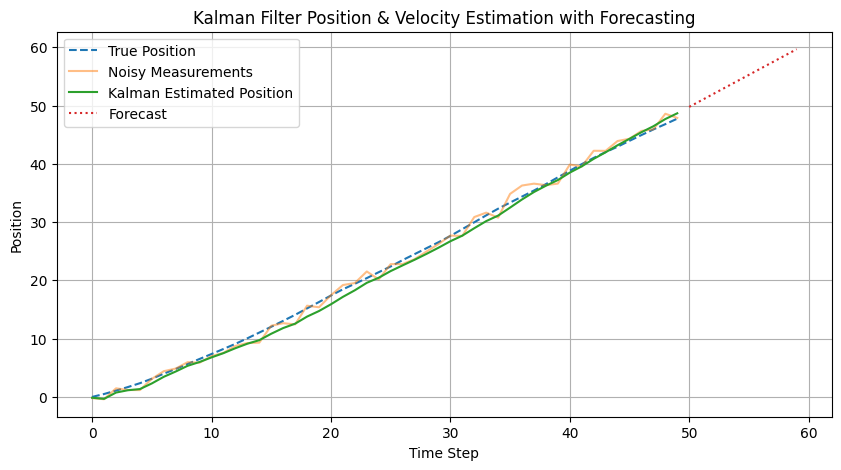

In [111]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)
n = 50

# True system: position increases with changing velocity
true_positions = np.zeros(n)
true_velocities = np.zeros(n)
true_positions[0] = 0
true_velocities[0] = 0.5
for t in range(1, n):
    true_velocities[t] = true_velocities[t-1] + np.random.normal(0, 0.05)  # velocity changes slightly
    true_positions[t] = true_positions[t-1] + true_velocities[t-1]

# Noisy measurements of position only
measurements = true_positions + np.random.normal(0, 1.0, n)

# Kalman filter initialization
x = np.array([0.0, 0.0])  # initial state: position=0, velocity=0
P = np.eye(2)             # initial uncertainty covariance matrix
dt = 1.0                  # time step

# State transition matrix
A = np.array([[1, dt],
              [0, 1]])

# Observation matrix (we only observe position)
H = np.array([[1, 0]])

# Process noise covariance (model uncertainty)
Q = np.array([[1e-4, 0],
              [0, 1e-4]])

# Measurement noise covariance
R = np.array([[1]])

x_estimates = []

for z in measurements:
    # Predict
    x = A @ x
    P = A @ P @ A.T + Q

    # Update
    y = z - (H @ x)             # Innovation/residual
    S = H @ P @ H.T + R         # Innovation covariance
    K = P @ H.T @ np.linalg.inv(S)  # Kalman gain

    x = x + K.flatten() * y     # Update state estimate
    P = (np.eye(2) - K @ H) @ P # Update covariance estimate

    x_estimates.append(x.copy())

x_estimates = np.array(x_estimates)

# Forecast future positions using last estimated velocity
future_steps = 10
forecast = []
last_state = x_estimates[-1]
for i in range(1, future_steps + 1):
    pos_forecast = last_state[0] + last_state[1] * i
    forecast.append(pos_forecast)

# Plotting results
plt.figure(figsize=(10, 5))
plt.plot(true_positions, label='True Position', linestyle='--')
plt.plot(measurements, label='Noisy Measurements', alpha=0.5)
plt.plot(x_estimates[:, 0], label='Kalman Estimated Position')
plt.plot(np.arange(n, n + future_steps), forecast, label='Forecast', linestyle=':')
plt.legend()
plt.title("Kalman Filter Position & Velocity Estimation with Forecasting")
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.grid(True)
plt.show()
